<a href="https://colab.research.google.com/github/zahra75koosha/zahra-koosha/blob/master/ccn_hoda_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 uninstall tensorflow
!pip3 install tensorflow.gpu==2.0.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/hoda dataset
%ls

/content/drive/My Drive/hoda dataset
 hoda_dataset_helper.py   RemainingSamples.cdb  'Train 60000.cdb'
 __pycache__/            'Test 20000.cdb'


In [0]:
from hoda_dataset_helper import read_hoda
from hoda_dataset_helper import __read_hoda_dataset
from hoda_dataset_helper import __read_hoda_cdb

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)

import tensorflow as tf
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator



Load Dataset

In [0]:
# Reading train dataset 
X_train, Y_train = __read_hoda_dataset(dataset_path='./Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=True, # set one hot= True to encode training_label to one hot vector
                                reshape=True)

In [0]:
# reading test dataset
X_test, Y_test = __read_hoda_dataset(dataset_path='./Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=True,
                              reshape=False)

In [0]:
# Reading remain samples dataset 
X_remain, Y_remain = __read_hoda_dataset('./RemainingSamples.cdb',
                                             images_height=32,
                                             images_width=32,
                                             one_hot=True,
                                             reshape=True)

In [0]:
# reading train image
train_images, train_labels = __read_hoda_cdb('./Train 60000.cdb')

In [0]:
# reading test image
test_images, test_labels = __read_hoda_cdb('./Test 20000.cdb')

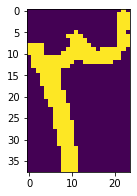

In [0]:
# plot a data sample

fig = plt.figure(figsize=(15, 3))
plt.imshow(train_images[12])

In [0]:
#normalization
X_train =X_train / 255.0
X_test = X_test /255.0

In [0]:
# reshape the train and remain samples to 3 dimension
X_train=X_train.reshape(-1,32,32,1)
X_remain=X_remain.reshape(-1,32,32,1)


In [0]:
print(f'shape of X_train : {X_train.shape}')
print(f'shape of Y_train : {Y_train.shape}')

print(f'shape of X_test i: {X_test.shape}')
print(f'shape of Y_test  : {Y_test.shape}')

print(f'shape of X_reamin : {X_remain.shape}')
print(f'shape of Y_remain : {Y_remain.shape}')

shape of X_train is : (60000, 32, 32, 1)
shape of Y_train is : (60000, 10)
shape of X_test is : (20000, 32, 32, 1)
shape of Y_test is : (20000, 10)
shape of X_reamin is : (22352, 32, 32, 1)
shape of Y_remain is : (22352, 10)


In [0]:
# split training dataset to validation and train samples
random_seed=2
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val= train_test_split(X_train,Y_train,test_size=0.1, random_state=random_seed)

In [0]:
print(f'shape of X_val is : {X_val.shape}')
print(f'shape of Y_val is : {Y_val.shape}')

shape of X_val is : (6000, 32, 32, 1)
shape of Y_val is : (6000, 10)


CNN model

In [0]:
model= Sequential()

model.add(Conv2D(32,(5,5), activation='relu', padding='same', input_shape=(32,32,1)))
model.add(Conv2D(32,(5,5), activation='relu', padding='same', input_shape=(32,32,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# classifier
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [0]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 8, 8, 64)        

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
epochs = 30 
batch_size = 32

In [0]:
result=model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                 validation_data=(X_val,Y_val), verbose=1,callbacks=[learning_rate_reduction])

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 26s 480us/sample - loss: 0.2480 - accuracy: 0.9147 - val_loss: 0.0379 - val_accuracy: 0.9887
Epoch 2/30
54000/54000 [==============================] - 25s 460us/sample - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.0666 - val_accuracy: 0.9813
Epoch 3/30
54000/54000 [==============================] - 25s 455us/sample - loss: 0.0335 - accuracy: 0.9902 - val_loss: 0.0244 - val_accuracy: 0.9918
Epoch 4/30
54000/54000 [==============================] - 25s 457us/sample - loss: 0.0318 - accuracy: 0.9909 - val_loss: 0.0236 - val_accuracy: 0.9932
Epoch 5/30
54000/54000 [==============================] - 25s 456us/sample - loss: 0.0313 - accuracy: 0.9922 - val_loss: 0.0190 - val_accuracy: 0.9943
Epoch 6/30
54000/54000 [==============================] - 25s 457us/sample - loss: 0.0295 - accuracy: 0.9926 - val_loss: 0.0235 - val_accuracy: 0.9945
Epoch 7/30
54000/54000 [=====================

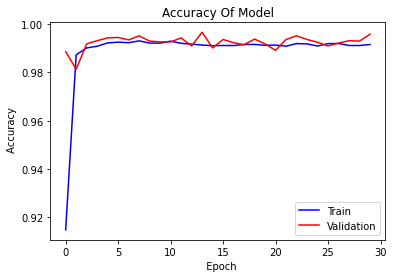

In [0]:
plt.plot(result.history['accuracy'], color='b', label='training accuracy')
plt.plot(result.history['val_accuracy'], color='r', label='validation accuracy')

plt.title('Accuracy Of Model')
plt.ylabel(' Accuracy')
plt.xlabel('  Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

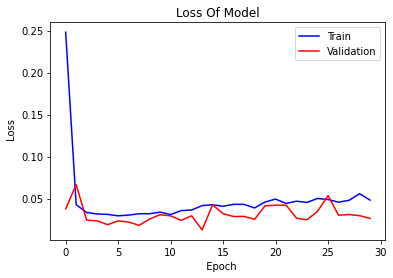

In [0]:

plt.plot(result.history['loss'], color='b', label='training loss')
plt.plot(result.history['val_loss'], color='r', label='validation loss')

plt.title('Loss Of Model')
plt.ylabel(' Loss')
plt.xlabel('  Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model.evaluate(X_val, Y_val, verbose=1)

6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0264708846124406, 0.99583334]

In [0]:
model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

20000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis = 1)

y_pred = pd.Series(y_pred,name="Label")

In [0]:
model.save("cnn_model.h5")

In [0]:
from tensorflow.keras.models import load_model
model_2 = load_model("cnn_model.h5")



In [0]:
model_2.summary()



Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 8, 8, 64)        